In [19]:
# Unnecessary on google colab
# %conda install pytorch torchvision -c pytorch
# %conda install -c fastai fastai

In [6]:
from fastai.vision.all import *
from fastcore.all import *
from fastai.callback.tracker import EarlyStoppingCallback
from sklearn.metrics import f1_score

## Single-label chest cancer classification

In [21]:
# !git clone https://github.com/davay/data5100.git # unnecessary on local

### Label and load images

In [28]:
path = 'data' # local
# path = 'data5100/data' # google colab
dls = ImageDataLoaders.from_folder(path,
                            train = 'train',
                            valid = 'valid',
                            test = 'test',
                            item_tfms = Resize(450, pad_mode='zeros'),
                            # item_tfms = RandomResizedCrop(450, min_scale = 0.75), # imagenet models often use 224 x 224. Our images aren't 1:1 aspect ratio, by default center crop will be used. We can add pad_mode='zeros' for no cropping.
                            batch_tfms=[*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)],
                            bs=32) # default is 64, local runs out of memory when used with densenet201

### Test the accuracy of stock imagenet model

In [23]:
# TODO: IN PROGRESS

# model = resnet34(pretrained = True)

# # switch to evaluation mode for inference rather than training
# model.eval()

### Retrain model on new data set

epoch,train_loss,valid_loss,error_rate,time
0,1.845376,1.597392,0.694444,00:04
1,1.610467,1.250308,0.513889,00:04
2,1.401255,0.948624,0.402778,00:04
3,1.128252,0.833053,0.319444,00:04
4,0.917600,0.788187,0.263889,00:04
5,0.745823,0.743284,0.208333,00:04
6,0.596210,0.731734,0.222222,00:04
7,0.495814,0.682455,0.180556,00:04
8,0.408834,1.016871,0.236111,00:04
9,0.355584,0.820971,0.236111,00:04


No improvement since epoch 25: early stopping


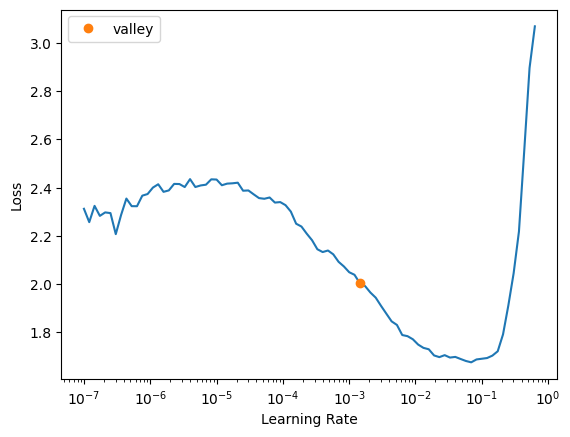

In [43]:
learn = vision_learner(dls, densenet201, metrics=error_rate)
lr_valley = learn.lr_find().valley
epoch = 50
div = 25
# learn.fit_one_cycle(epoch, lr_valley)
learn.fit_one_cycle(epoch, lr_valley, div, cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.01, patience=10)])

### Evaluate performance of retrained model

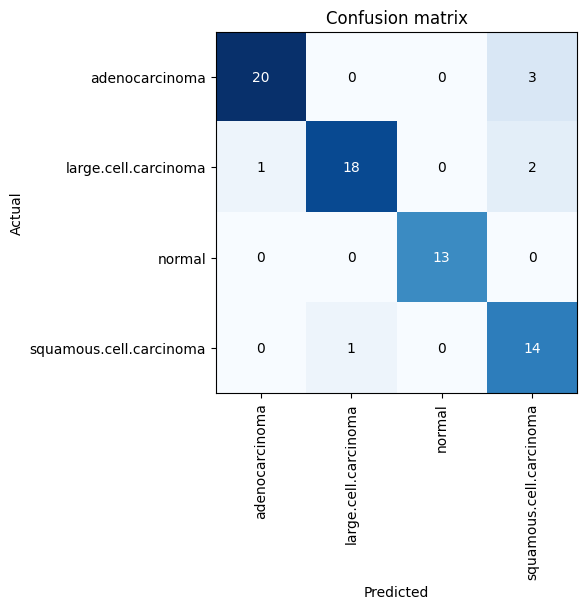

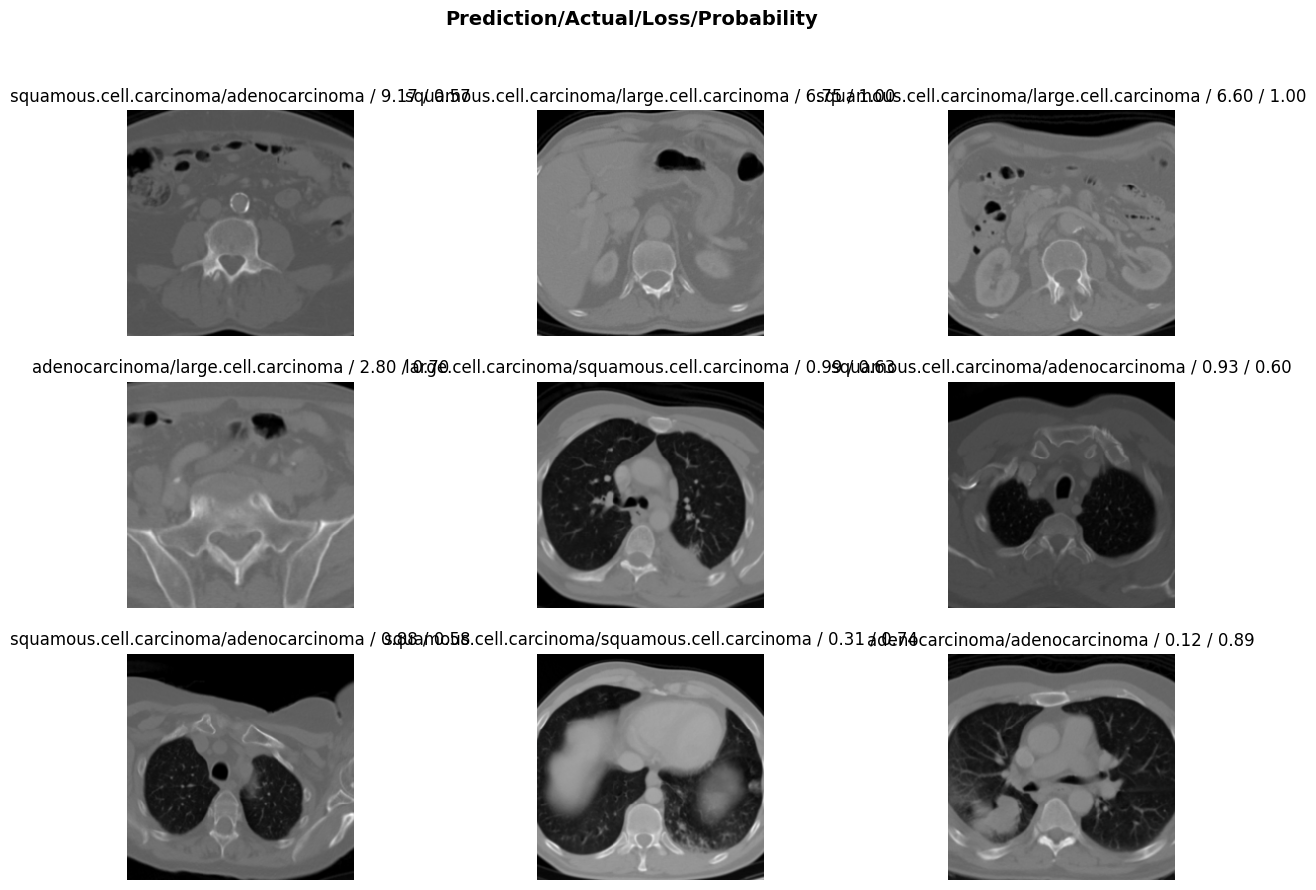

In [44]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))
interp.plot_top_losses(9, figsize=(15,10)) # TODO: fix overlapping text

In [41]:
# Define a custom F1 score metric for Fastai
f1score_fastai = skm_to_fastai(f1_score, average='macro')

# Append the F1 score metric
learn.metrics.append(f1score_fastai)

# Validate and print F1 Score
val_f1score = learn.recorder.values[-1][2]  # Index 2 corresponds to the F1 score

print(f"F1 Score: {val_f1score}")

F1 Score: 0.9079545454545455


In [1]:
from fastai.vision.all import *
from fastcore.all import *
from fastai.callback.tracker import EarlyStoppingCallback
from sklearn.metrics import f1_score

base_models = [
    resnet18,
    resnet50,
    resnet152,
    densenet121, 
    densenet201
    ]

fit_options = [
    {"method": "fine_tune", "n_epoch": 50}, 
    {"method": "fit_one_cycle", "n_epoch": 50},
    {"method": "fit_one_cycle", "n_epoch": 50, "lr_max": "lr_find().valley", "early_stop": {"patience": 3}},
    {"method": "fit_one_cycle", "n_epoch": 50, "lr_max": "lr_find().valley", "div": 10, "early_stop": {"patience": 3}}, # this is per resnet paper <link>
    {"method": "fit_one_cycle", "n_epoch": 50, "lr_max": "lr_find().valley", "early_stop": {"patience": 10}},
]

item_tfms_options = [
    "Resize(224)",
    "Resize(224, pad_mode='zeros')",
    "Resize(450, pad_mode='zeros')",
    "RandomResizedCrop(450, min_scale=0.75)" # from fastai paper
    ]

batch_tfms_options = [
    "None",
    "aug_transforms()", 
    "[*aug_transforms(size=224, max_warp=0.), Normalize.from_stats(*imagenet_stats)]" # from fastai paper https://arxiv.org/abs/2002.04688
    ]

# path = 'data' # local
path = 'data5100/data' # google colab

# DataFrame to store results
results = pd.DataFrame(columns=["Base Model", "Fit Method", "n_epoch", "lr_max", "div", "patience", "item_tfms", "batch_tfms", "F1 Score"])

def evaluate(learner):
    f1score_fastai = skm_to_fastai(f1_score, average='macro')
    learner.metrics.append(f1score_fastai)
    f1 = learner.recorder.values[-1][2]  # Index 2 corresponds to the F1 score
    return f1

# Iterate over all combinations
for base_model in base_models:
    for fit_option in fit_options:
        for batch_tfms in batch_tfms_options:
            for item_tfms in item_tfms_options:

                print("BASE MODEL: " + str(base_model)) 
                print("FIT OPTION: " + str(fit_option))
                print("ITEM TFMS: " + str(item_tfms)) 
                print("BATCH TFMS: " + str(batch_tfms))

                exec(f"item_tfms_obj = {item_tfms}") # Hacky way to grab the pre-evaluated option for cleaner output
                exec(f"batch_tfms_obj = {batch_tfms}")
                dls = ImageDataLoaders.from_folder(
                    path,
                    train='train',
                    valid='valid',
                    test='test',
                    item_tfms=item_tfms_obj,
                    batch_tfms=batch_tfms_obj,
                    bs=32) # default batch size is 64, local runs out of memory when used with densenet201
                
                learn = vision_learner(dls, base_model, metrics=error_rate)
               
                lr_valley = learn.lr_find().valley if fit_option.get("lr_max", None) == "lr_find().valley" else None
                early_stop_params = fit_option.get("early_stop", None)
                cbs = EarlyStoppingCallback(
                    monitor='valid_loss', 
                    min_delta=0.01, 
                    patience=early_stop_params.get("patience", 1) # default patience value is 1 - shouldn't get used tho
                ) if early_stop_params else None
                div = fit_option.get("div", 25)
                if fit_option["method"] == "fit_one_cycle":
                    learn.fit_one_cycle(fit_option["n_epoch"], lr_valley, div=div if div else None, cbs=cbs if cbs else None)

                if fit_option["method"] == "fine_tune":
                    learn.fine_tune(fit_option["n_epoch"])

                # Calculate F1 score
                f1 = evaluate(learn)

                # Record the results
                results = pd.concat([results, pd.DataFrame([{
                    "Base Model": base_model.__name__,
                    "Fit Method": fit_option["method"],
                    "n_epoch": fit_option["n_epoch"],
                    "lr_max": str(fit_option.get("lr_max", None)) + f" -> {lr_valley}",
                    "div": fit_option.get("div", 25),
                    "patience": fit_option["early_stop"]["patience"] if fit_option.get("early_stop", None) else 1,
                    "item_tfms": item_tfms,
                    "batch_tfms": batch_tfms,
                    "F1 Score": f1
                }])], ignore_index=True)

# results

# Export results to CSV
results.to_csv("model_performance.csv")

/home/davay/.conda/envs/data5100/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


BASE MODEL: <function resnet18 at 0x7f01eb26e520>
FIT OPTION: {'method': 'fine_tune', 'n_epoch': 50}
ITEM TFMS: Resize(224)
BATCH TFMS: None


epoch,train_loss,valid_loss,error_rate,time
0,1.694763,1.781071,0.569444,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.895253,1.656740,0.486111,00:01
1,0.711708,0.975536,0.347222,00:01
2,0.600908,0.819225,0.361111,00:01
3,0.493269,0.738240,0.236111,00:01
4,0.402891,0.795435,0.291667,00:01
5,0.315832,0.709383,0.250000,00:01
6,0.255277,0.788995,0.291667,00:01


KeyboardInterrupt: 